This analyzes the more detailed run, used to examine precise measures of the quality of bistability. It only uses a subset of the parameter space, as the first run (in the complimentary `Plots of Multiple Levels.ipy` file) eliminates the obviously bad parameters that do not any bistability.

# Setup

In [15]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-10-12")

"../data/count_lengths/run_2018-10-12"

# Load and Summarize Data

In [16]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)

results = []
for_results_in(joinpath(datadir,"data")) do entry
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [17]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

47.78

In [18]:
function handlebound(fn,seconds;bound=true,threshold=0.8)
    if bound && length(seconds) < 3
        return missing
    end
    
    if !bound || (sum(seconds[2:end-1]) > threshold*sum(seconds))
        fn(1:length(seconds))
    else
        fn(2:length(seconds)-1)
    end
end

handlebound (generic function with 1 method)

In [19]:
function streamprop(percepts,seconds;kwds...)
    handlebound(seconds;kwds...) do range
        sum(seconds[range][percepts[range] .== 2]) / sum(seconds[range])
    end
end

streamprop (generic function with 1 method)

In [29]:
function stim_per_second(seconds;kwds...)
    handlebound(seconds;kwds...) do range
        length(range) / sum(seconds[range])
    end
end
        

stim_per_second (generic function with 1 method)

In [43]:
df_summary = @linq df |>
  by(:pindex,
     num_sims = length(unique(:created)),
     stim_rate = stim_per_second(:length),
     mu = exp.(mean(log.(:length))),
     skew = skewness(log.(:length)),
     kurt = kurtosis(log.(:length)),
     streamprop = streamprop(:percepts,:length,bound=true)) |>
  join(params,on = :pindex) |>
  transform(f_c_a = round.(:f_c_a), f_c_m = round.(:f_c_m),
            s_c_a = round.(:s_c_a), s_c_m = round.(:s_c_m),
            t_c_a = round.(:t_c_a), t_c_m = round.(:t_c_m));

# Balance of Streaming Responses

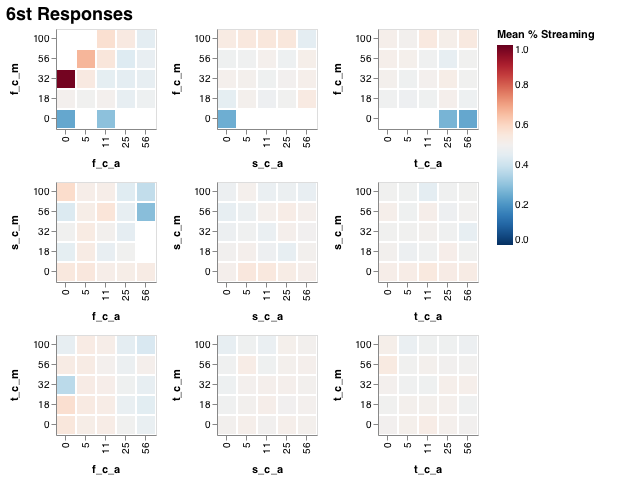

In [60]:
@where(df_summary,:Δf .== 6) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          title={text="6st Responses",fontSize=18},config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field="streamprop", typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="Mean % Streaming"}})

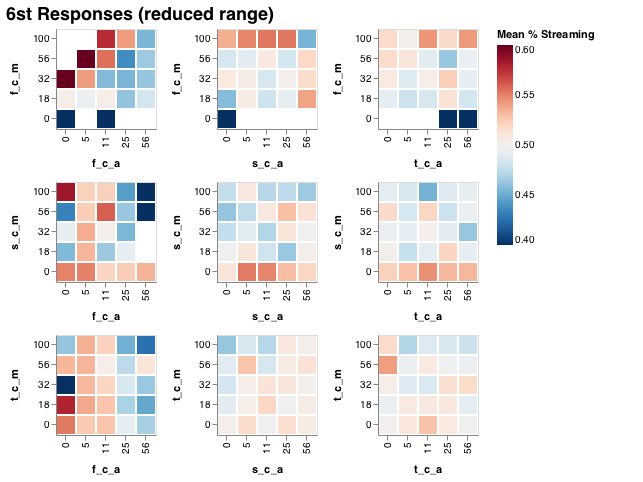

In [61]:
@where(df_summary,:Δf .== 6) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          title={text="6st Responses (reduced range)",fontSize=18},config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field="streamprop", typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0.4,0.6],range="diverging"},
                 legend={title="Mean % Streaming"}})

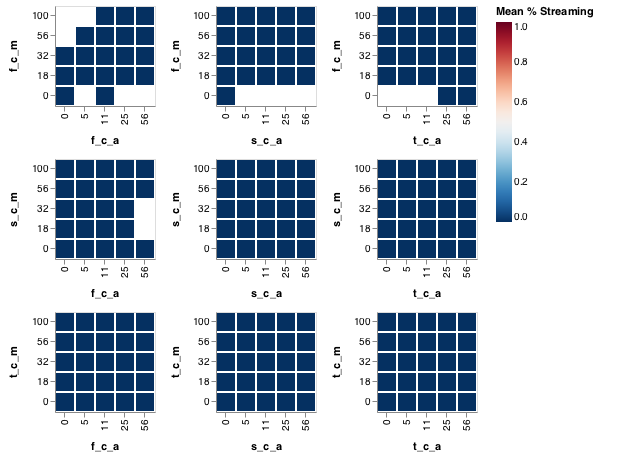

In [63]:
@where(df_summary,:Δf .== 3) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field="streamprop", typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="Mean % Streaming"}})

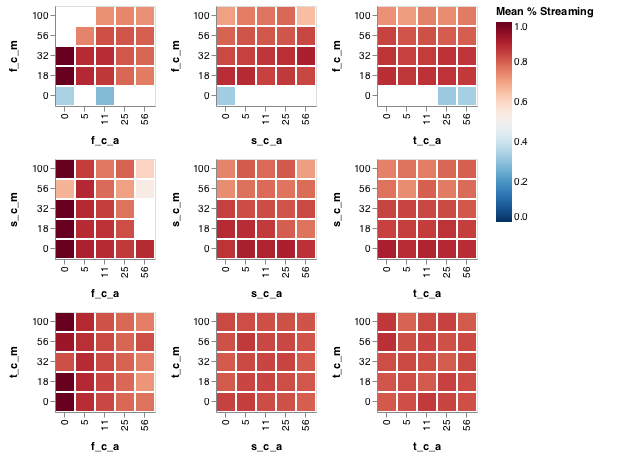

In [64]:
@where(df_summary,:Δf .== 12) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field="streamprop", typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0,1],range="diverging"},
                 legend={title="Mean % Streaming"}})

In [66]:
mean_human = [0.11, 0.55, 0.89]
function stream_rms(str3,str6,str12)
  vec(sqrt.(mean((hcat(str3,str6,str12) .- mean_human').^2,dims=2)))
end

stream_rms (generic function with 1 method)

In [140]:
df_stream_rms = @linq df_summary |>
  select(:f_c_a,:f_c_m,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:Δf,:streamprop) |>
  unstack(:Δf,:streamprop) |>
  rename(Symbol("3") => :Δf_3,Symbol("6") => :Δf_6,Symbol("12") => :Δf_12) |>
  transform(stream_rms = stream_rms(:Δf_3,:Δf_6,:Δf_12));

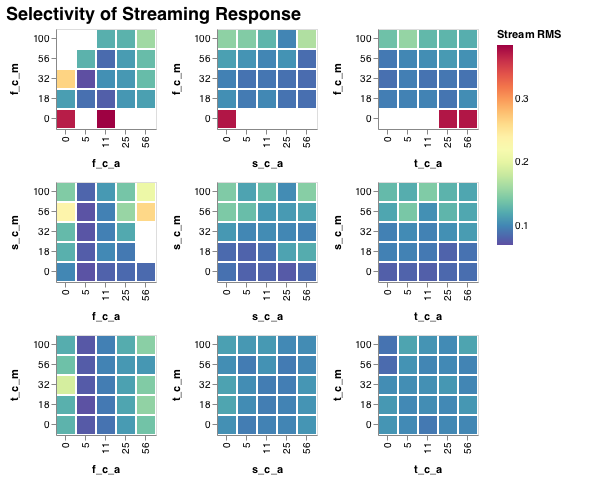

In [162]:
df_stream_rms |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          title={text="Selectivity of Streaming Response",fontSize=18},config={range={heatmap={scheme="spectral"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:stream_rms, typ="quantitative", aggregate="mean",
                 sort = "descending",scale={range="heatmap"},
                 legend={title="Stream RMS"}})

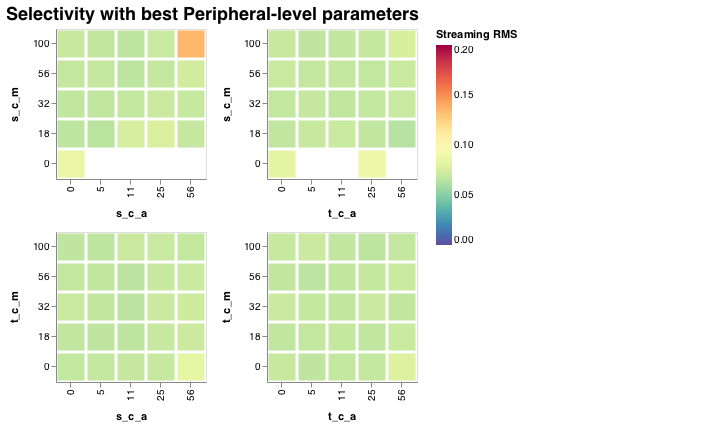

In [160]:
@where(df_stream_rms,(:f_c_m .== 32) .& (:f_c_a .== 5)) |>
  @vlplot(repeat={row=[:s_c_m,:t_c_m],column=[:s_c_a,:t_c_a]},
          title={text="Selectivity with best Peripheral-level parameters",fontSize=18},config={range={heatmap={scheme="spectral"}}}) +
  @vlplot(:rect, width=150, height=150,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:stream_rms, typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0,0.2],range="heatmap"},
                 legend={title="Streaming RMS"}})

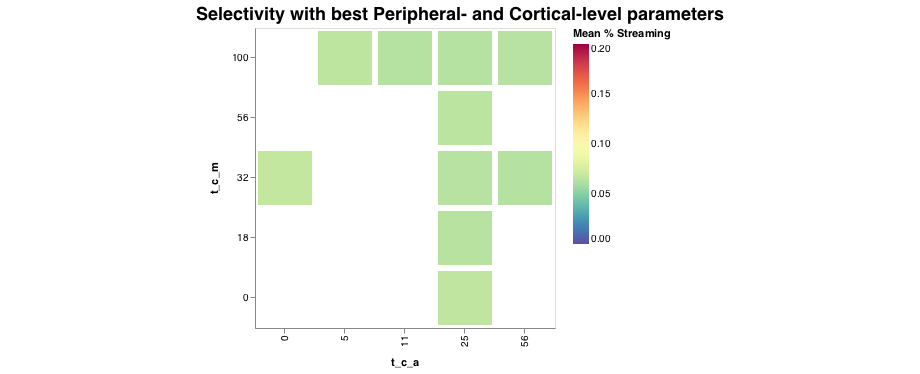

In [90]:
@where(df_stream_rms,(:f_c_m .== 32) .& (:f_c_a .== 5) .& (:s_c_a .== 5) .& (:s_c_m .== 18)) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Selectivity with best Peripheral- and Cortical-level parameters",fontSize=18},
          config={range={heatmap={scheme="spectral"}}},
          x={field=:t_c_a,typ="ordinal"}, 
          y={field=:t_c_m,typ="ordinal", sort="descending"},
          color={field=:stream_rms, typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0,0.2],range="heatmap"},
                 legend={title="Mean % Streaming"}})

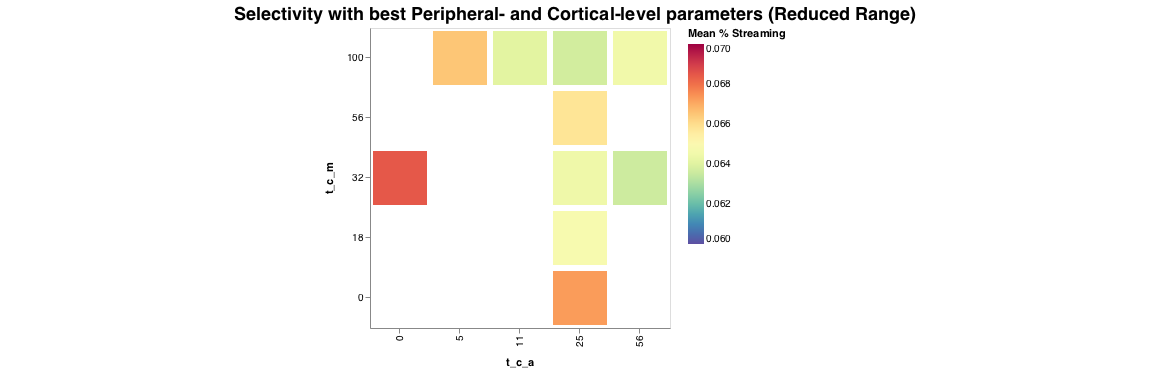

In [94]:
@where(df_stream_rms,(:f_c_m .== 32) .& (:f_c_a .== 5) .& (:s_c_a .== 5) .& (:s_c_m .== 18)) |>
  @vlplot(:rect, width=300, height=300,
          title={text="Selectivity with best Peripheral- and Cortical-level parameters (Reduced Range)",fontSize=18},
          config={range={heatmap={scheme="spectral"}}},
          x={field=:t_c_a,typ="ordinal"}, 
          y={field=:t_c_m,typ="ordinal", sort="descending"},
          color={field=:stream_rms, typ="quantitative", aggregate="mean",
                 sort = "descending",scale={domain=[0.06,0.07],range="heatmap"},
                 legend={title="Mean % Streaming"}})

# Count

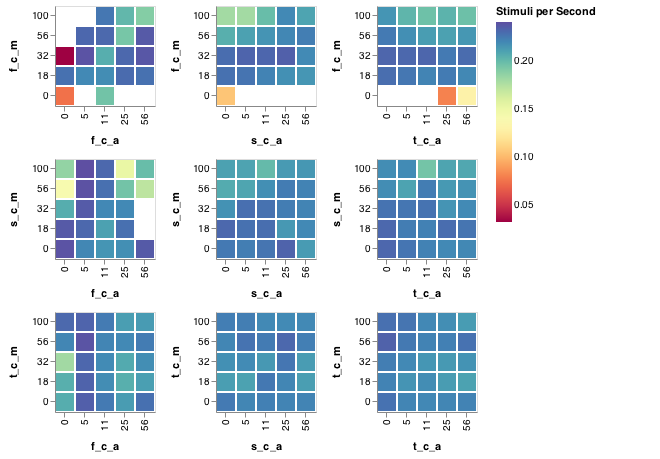

In [96]:
@select(@where(df_summary,:Δf .== 6),:f_c_m,:f_c_a,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:stim_rate) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          config={range={heatmap={scheme="spectral"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:stim_rate, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={range="heatmap"},
                 legend={title="Stimuli per Second"}})

# Log Normality

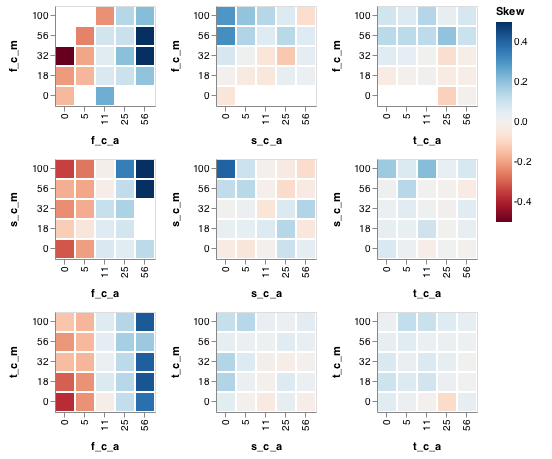

In [113]:
@select(@where(df_summary,:Δf .== 6),:f_c_m,:f_c_a,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:skew) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:skew, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={domain=[-0.5,0.5],range="diverging"},
                 legend={title="Skew"}})

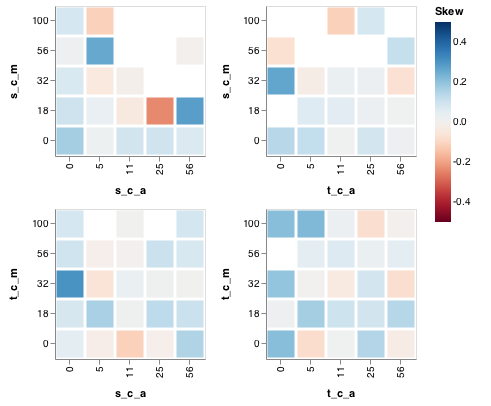

In [114]:
@select(@where(df_summary,:Δf .== 6,(:f_c_m .== 32) .& (:f_c_a .== 11)),:f_c_m,:f_c_a,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:skew) |>
  @vlplot(repeat={row=[:s_c_m,:t_c_m],column=[:s_c_a,:t_c_a]},
          config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=150, height=150,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:skew, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={domain=[-0.5,0.5],range="diverging"},
                 legend={title="Skew"}})

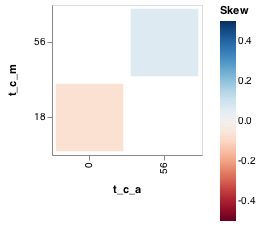

In [115]:
@select(@where(df_summary,:Δf .== 6,(:f_c_m .== 32) .& (:f_c_a .== 11) .& (:s_c_a .== 56) .& (:s_c_m .== 56)),:t_c_a,:t_c_m,:skew) |>
  @vlplot(:rect, width=150, height=150,
          x={field=:t_c_a,typ="ordinal"}, 
          y={field=:t_c_m,typ="ordinal", sort="descending"},
          color={field=:skew, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={domain=[-0.5,0.5],range="diverging"},
                 legend={title="Skew"}},
          config={range={diverging={scheme="redblue"}}})

# Kurtosis

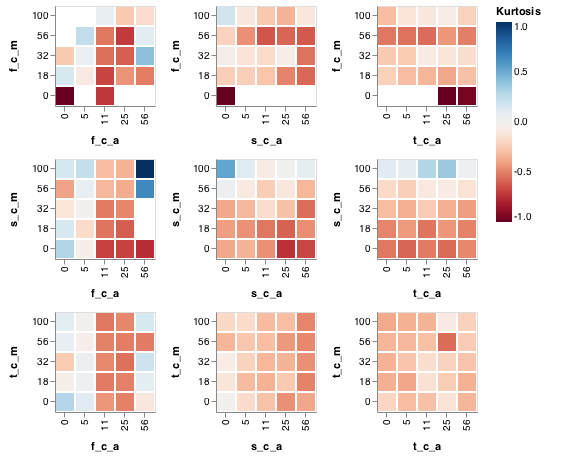

In [117]:
@select(@where(df_summary,:Δf .== 6),:f_c_m,:f_c_a,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:kurt) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:kurt, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={domain=[-1,1],range="diverging"},
                 legend={title="Kurtosis"}})

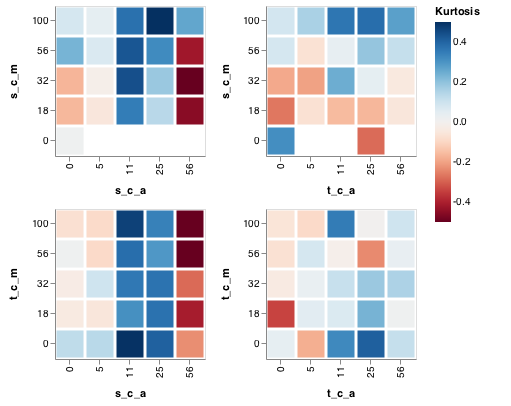

In [119]:
@select(@where(df_summary,:Δf .== 6,(:f_c_m .== 32) .& (:f_c_a .== 5)),:f_c_m,:f_c_a,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:kurt) |>
  @vlplot(repeat={row=[:s_c_m,:t_c_m],column=[:s_c_a,:t_c_a]},
          config={range={diverging={scheme="redblue"}}}) +
  @vlplot(:rect, width=150, height=150,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:kurt, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={domain=[-0.5,0.5],range="diverging"},
                 legend={title="Kurtosis"}})

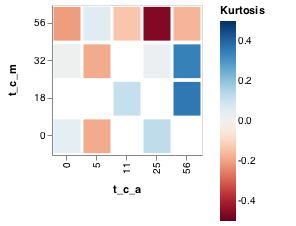

In [126]:
@select(@where(df_summary,:Δf .== 6,(:f_c_m .== 32) .& (:f_c_a .== 5) .& (:s_c_a .== 5) .& (:s_c_m .== 32)),:t_c_a,:t_c_m,:kurt) |>
  @vlplot(:rect, width=150, height=150,
          x={field=:t_c_a,typ="ordinal"}, 
          y={field=:t_c_m,typ="ordinal", sort="descending"},
          color={field=:kurt, typ="quantitative", aggregate="mean",
                 sort = "descendng",scale={domain=[-0.5,0.5],range="diverging"},
                 legend={title="Kurtosis"}},
          config={range={diverging={scheme="redblue"}}})

# Overal RMS

In [138]:
rms(x) = any(x -> ismissing(x) | isnan(x),x) ? 100 : sqrt(mean(x.^2))

rms (generic function with 1 method)

In [143]:
df_normal = @linq df_summary |> 
  where(:Δf .== 6) |> 
  select(:f_c_a,:f_c_m,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:kurt,:skew)

df_combined = join(df_stream_rms,df_normal,on = [:f_c_a,:f_c_m,:s_c_a,:s_c_m,:t_c_a,:t_c_m])
# for our purposes here we are going to say a kurtosis of 2, a skewness of 1, and a stream deviation of 0.5 are equivalent
# in the final analysis, we should z-score these statistics based on the human data
df_combined = @transform(df_combined,rms = vec(mapslices(rms,[:stream_rms./0.5 :skew./2 :kurt./2],dims=2)))

1084×13 DataFrame. Omitted printing of 6 columns
│ Row  │ f_c_a   │ f_c_m   │ s_c_a   │ s_c_m   │ t_c_a   │ t_c_m   │ Δf_3     │
│      │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64⍰ │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────┤
│ 1    │ 0.0     │ 0.0     │ 0.0     │ 56.0    │ 25.0    │ 32.0    │ 0.0      │
│ 2    │ 0.0     │ 0.0     │ 0.0     │ 56.0    │ 25.0    │ 56.0    │ 0.0      │
│ 3    │ 0.0     │ 0.0     │ 0.0     │ 56.0    │ 56.0    │ 32.0    │ 0.0      │
│ 4    │ 0.0     │ 18.0    │ 0.0     │ 0.0     │ 0.0     │ 100.0   │ 0.0      │
│ 5    │ 0.0     │ 18.0    │ 0.0     │ 0.0     │ 11.0    │ 0.0     │ 0.0      │
│ 6    │ 0.0     │ 18.0    │ 0.0     │ 0.0     │ 25.0    │ 18.0    │ 0.0      │
│ 7    │ 0.0     │ 18.0    │ 0.0     │ 0.0     │ 25.0    │ 100.0   │ 0.0      │
│ 8    │ 0.0     │ 18.0    │ 0.0     │ 18.0    │ 0.0     │ 0.0     │ 0.0      │
│ 9    │ 0.0     │ 18.0    │ 0.0     │ 18.0    │ 0.0     │ 18.0    │ 0.0      │
│ 10   │ 0.0     │ 18.0    │ 0.0     │ 18.0    │ 0.0     │ 100.0   │ 0.0      │
⋮
│ 1074 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 5.0     │ 0.0     │ 0.0      │
│ 1075 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 5.0     │ 100.0   │ 0.0      │
│ 1076 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 11.0    │ 0.0     │ 0.0      │
│ 1077 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 11.0    │ 56.0    │ 0.0      │
│ 1078 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 25.0    │ 0.0     │ 0.0      │
│ 1079 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 25.0    │ 32.0    │ 0.0      │
│ 1080 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 56.0    │ 0.0     │ 0.0      │
│ 1081 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 56.0    │ 32.0    │ 0.0      │
│ 1082 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 56.0    │ 56.0    │ 0.0      │
│ 1083 │ 56.0    │ 100.0   │ 25.0    │ 0.0     │ 56.0    │ 100.0   │ 0.0      │
│ 1084 │ 56.0    │ 100.0   │ 56.0    │ 0.0     │ 5.0     │ 32.0    │ 0.0      │

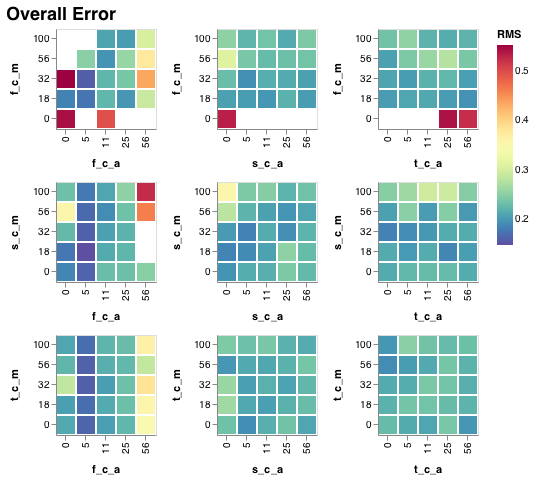

In [152]:
@select(df_combined,:f_c_m,:f_c_a,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:rms) |>
  @vlplot(repeat={row=[:f_c_m,:s_c_m,:t_c_m],column=[:f_c_a,:s_c_a,:t_c_a]},
          config={range={heatmap={scheme="spectral"}}},
          title={text="Overall Error",fontSize=18}) + 
  @vlplot(:rect, width=100, height=100,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:rms, typ="quantitative", aggregate="mean",
                 sort="descending",scale={range="heatmap"},
                 legend={title="RMS"}})

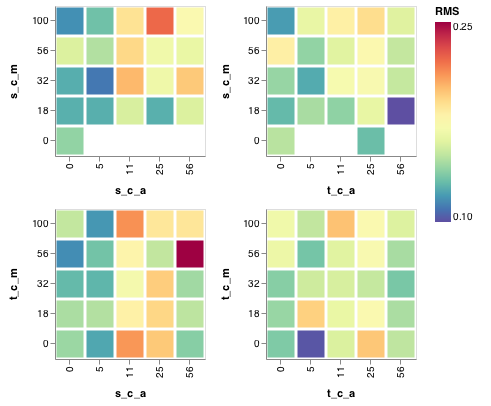

In [156]:
@select(@where(df_combined,(:f_c_m .== 32) .& (:f_c_a .== 5)),:s_c_a,:s_c_m,:t_c_a,:t_c_m,:rms) |>
  @vlplot(repeat={row=[:s_c_m,:t_c_m],column=[:s_c_a,:t_c_a]},
          config={range={heatmap={scheme="spectral"}}}) +
  @vlplot(:rect, width=150, height=150,
          x={field={repeat=:column},typ="ordinal"}, 
          y={field={repeat=:row},typ="ordinal", sort="descending"},
          color={field=:rms, typ="quantitative", aggregate="mean",
                 sort="descending",scale={range="heatmap"},
                 legend={title="RMS"}})

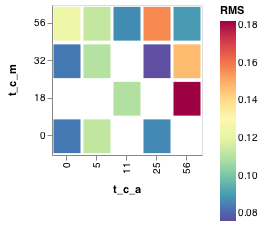

In [159]:
@select(@where(df_combined,(:f_c_m .== 32) .& (:f_c_a .== 5) .& (:s_c_m .== 32) .& (:s_c_a .== 5)),:t_c_a,:t_c_m,:rms) |>
  @vlplot(:rect, width=150, height=150,
          x={field=:t_c_a,typ="ordinal"}, 
          y={field=:t_c_m,typ="ordinal", sort="descending"},
          color={field=:rms, typ="quantitative", aggregate="mean",
                 sort="descending",scale={range="heatmap"},
                 legend={title="RMS"}},
          config={range={heatmap={scheme="spectral"}}})

In [163]:
columns = [:f_c_a,:f_c_m,:s_c_a,:s_c_m,:t_c_a,:t_c_m,:rms]
variables = convert(Array,df_combined[columns])
variables .-= mean(variables,dims=1)
variables ./= std(variables,dims=1)
pc = svd(variables);
# cca = fit(CCA,permutedims(variables[:,1:6]),permutedims(variables[:,7]))

In [165]:
PCs = pc.U*Diagonal(pc.S);

for i in 1:7
    df_combined[Symbol.("pc$i")] = PCs[:,i]
end

In [166]:
cumsum(pc.S.^2 ./ sum(pc.S.^2))

7-element Array{Float64,1}:
 0.24512181609078176
 0.41888081678152933
 0.575989538895859  
 0.7197199131852214 
 0.8564674195884351 
 0.9636885197283421 
 0.9999999999999999 

In [167]:
# show the principle components
df_comp = DataFrame(
    val = vec(pc.Vt), 
    variable = string.(vec(map(x -> columns[x.I[2]],CartesianIndices(pc.Vt)))),
    component = float.(vec(map(x -> x.I[1],CartesianIndices(pc.Vt)))));

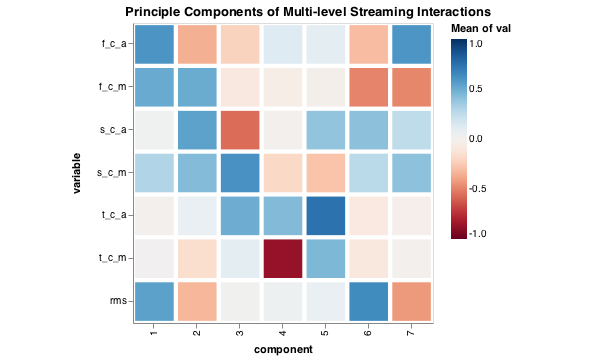

In [168]:
df_comp |> 
    @vlplot(:rect, width = 300, height = 300,
        title={text="Principle Components of Multi-level Streaming Interactions"},
        x={field=:component,typ="ordinal"},
        y={field=:variable,typ="ordinal", sort=["f_c_a","f_c_m","s_c_a","s_c_m","t_c_a","t_c_m","streamprop"]}, 
        color={field=:val, aggregate="mean", typ="quantitative", scale={domain=[-1,1],range="diverging"}},
        config={range={diverging={scheme="redblue"}}})

The below plot shows the mean when components 1 and 7 are held constant across the remaining 5 components. (These two components account for the most variance in `streamprop`, as shown in the figure above.

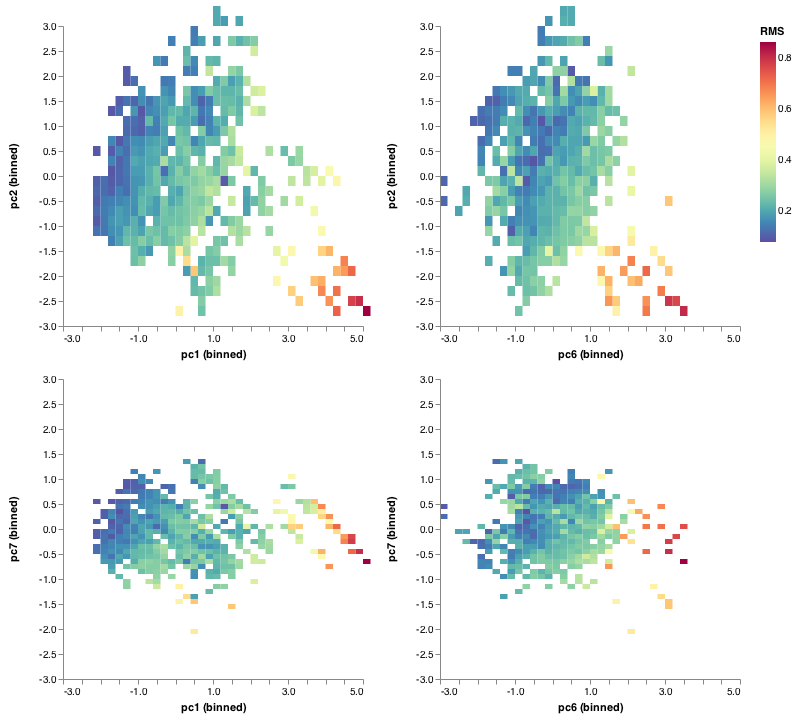

In [179]:
@select(df_combined,:pc1,:pc2,:pc6,:pc7,:rms) |>
  @vlplot(repeat={column=[:pc1,:pc6],row=[:pc2,:pc7]},
          config={range={heatmap={scheme="spectral"}},
                  view={stroke="transparent"}}) + 
  @vlplot(:rect, width=300, height=300,
          x={field={repeat=:column},bin={maxbins=50},typ="quantitative", scale={domain=[-3.0,5]}}, 
          y={field={repeat=:row},bin={maxbins=50},typ="quantitative", scale={domain=[-3,3]}},
          color={field=:rms, typ="quantitative", aggregate="mean",
                 sort = "descending",scale={range="heatmap"},
                 legend={title="RMS"}})